# E-tivity 2 Weeks 3-4

* Barry Clarke

* 24325082

## Outline

This e-tivity is split into two parts. The first part <a href="#part1">**Stock Predicition**</a> is a group activity where you are tasked with predicting the stock market.

The second <a href="#part2">**Sentiment Analysis**</a> is an individual task, the problem is to predict if a film review is positive or negative.

### Guidelines

The e-tivity is split into five tasks. The first four are "group" excersises, in that you post the solutions to Tasks 1-4 to the Group Locker. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to Brightspace.

Marks will be deducted if task 5 is uploaded in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-5 and with correct identification or filename.


Grading guidelines: the rubrics for the e-tivity are here https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4446&originTool=quicklinks





<a id='part1'></a>
## Stock Prediction

### Context

There is a small dataset of real stock prices for each working day from the end of 2015 to the end of 2019. There are four variables (with a time stamp), stock price, oil price, gold price and Euro to Dollar exchange. You need to predict the Stock price a day ahead from only the past values of each of the 4 variables.


### Tasks 1-4 (complete by Sunday Week 4)

Create additional cells to complete the tasks below. These form the group exercises and you can upload your code for Tasks 1-4 to the group locker.

**Task 1: data preprocessing**

Explain any preprocessing steps you take including but limited to reformatting and also how you have selected the training and test sets. The test set should be 20% of the whole.

**Task 2: data cleaning**

There are a number of missing values in the data. Clean the data so that it is suitable for use with the NN. Bare in mind that you want to retain the time coherency of the data as much as possible. Explain the steps you have taken.

**Task 3: model construction**

Construct a RNN network that will predict the future value of Stock, one day/time inteval in advance.

**Task 4: test**

Evaluate the model on the test set and display any change in accuracy over time, if any. Test for common issues found in deep learning models.

### Post (complete by Sunday Week 3)

Please upload your code for Tasks 1-4 to the group locker by Sunday if possible. The implementation does not need to be complete and you can continue to upload improved versions. The link is below. To organise things well; create a new subfolder in the locker for your work. You can upload multiple copies with different filenames to archive development stages. Post the link to the forum/topic. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

Post the location to the appropriate forum/topic.

No posts should reference Task 5.

### Respond (complete by Wednesday Week 4)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

The group interaction forms part of the overall assessment. Grading guidelines for the forum posts: the rubrics for the e-tivity are here
https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4446&originTool=quicklinks

### Final Submission (complete by Sunday Week 4)

Submit Tasks 1-5 in a single notebook this before the deadline on Sunday.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# REF: https://swngui.medium.com/how-to-use-ridge-regression-to-predict-a-stock-price-1b0099320ef4
# REF: https://medium.com/biased-algorithms/ridge-regression-implementation-in-python-dddd50324263
# REF: https://todatabeyond.substack.com/p/hands-on-time-series-analysis-with-017

Training Samples: 824, Test Samples: 206

      QUANTITATIVE MODEL REPORT

--- 1. ERROR ANALYSIS ---
Average STOCK Price:  $2962
Ridge MAE:            $15.19
Ridge RMSE:           $19.84
Ridge MAPE:           0.52%

--- 2. BENCHMARK COMPARISON ---
Ridge MAE:    $15.19
Naive MAE:    $15.37

--- 3. VERDICT ---
SUCCESS: Ridge Regression BEATS the Naive Baseline
   Improvement: $0.18 per share


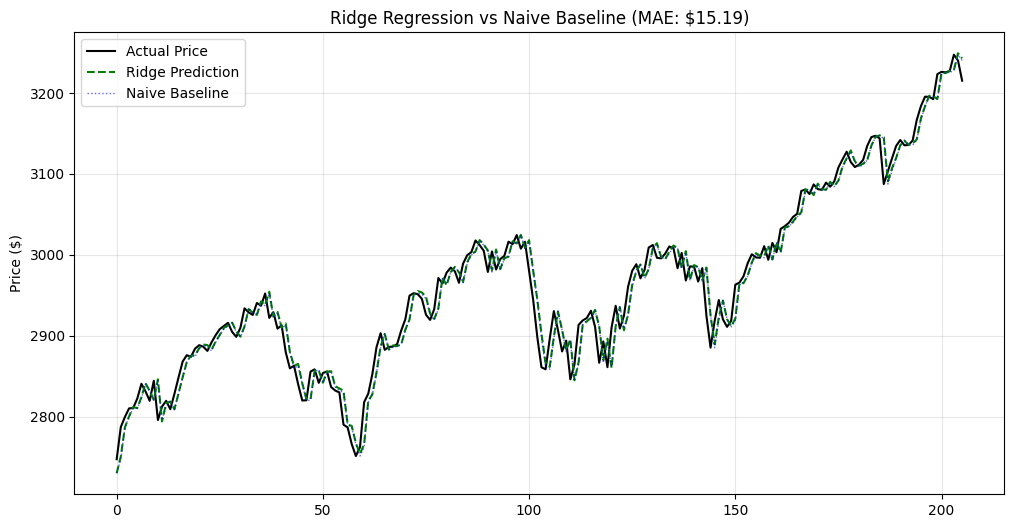

In [47]:
# ==========================================
# 1. DATA LOADING & FEATURE ENGINEERING
# ==========================================
# The dataset is loaded, chronologically sorted, and missing values are filled using forward fill (ffill)
# to prevent look-ahead bias
df = pd.read_csv('stock.csv', parse_dates=['Date'], index_col='Date').sort_index().ffill()

# Data Transformation: Daily Returns
# Raw prices are converted to percentage returns to make the data stationary (remove trends)
df['Stock_ret'] = df['Stock'].pct_change()
df['Oil_ret'] = df['Oil'].pct_change()
df['Gold_ret'] = df['Gold'].pct_change()
df['FX_ret'] = df['EuroToDollar'].pct_change()

# Feature Engineering: Lagged Returns (t-1)
# Yesterday's returns are aligned with the current row to serve as predictors
df['Stock_lag1'] = df['Stock_ret'].shift(1)
df['Oil_lag1']   = df['Oil_ret'].shift(1)
df['Gold_lag1']  = df['Gold_ret'].shift(1)
df['FX_lag1']    = df['FX_ret'].shift(1)

# Target Variable Generation: Next Day's Return (t+1)
# The stock return is shifted backwards to create the target variable for the next trading day
df['Stock_next_ret'] = df['Stock_ret'].shift(-1)

# Rows with NaN values resulting from the shift operations are removed
df = df.dropna()

# Definition of Feature Matrix (X) and Target Vector (y)
features = ['Stock_lag1', 'Oil_lag1', 'Gold_lag1', 'FX_lag1']
X = df[features].values
y = df['Stock_next_ret'].values

# Current prices are stored for later reconstruction of dollar values
current_prices = df['Stock'].values

# ==========================================
# 2. SPLITTING & SCALING
# ==========================================
# The dataset is split chronologically into Training (80%) and Testing (20%) sets
split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
prices_train, prices_test = current_prices[:split], current_prices[split:]

# Feature Scaling
# The scaler is fitted only on the training data to avoid data leakage
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training Samples: {len(X_train)}, Test Samples: {len(X_test)}")

# ==========================================
# 3. RIDGE REGRESSION MODEL
# ==========================================
# The model uses L2 regularisation to prevent overfitting
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# The model generates predictions for the test set
pred_returns = ridge.predict(X_test_scaled)

# ==========================================
# 4. RECONSTRUCTION & METRICS
# ==========================================
# Price Reconstruction
# Actual and predicted future prices are calculated from the returns
actual_next_prices = prices_test * (1 + y_test)
pred_next_prices   = prices_test * (1 + pred_returns)

# Naive Baseline Construction
# The baseline assumes the future price equals the current price
naive_next_prices  = prices_test

# Performance Metrics
ridge_mae = mean_absolute_error(actual_next_prices, pred_next_prices)
ridge_rmse = np.sqrt(mean_squared_error(actual_next_prices, pred_next_prices))
ridge_mape = np.mean(np.abs((actual_next_prices - pred_next_prices) / actual_next_prices)) * 100
naive_mae = mean_absolute_error(actual_next_prices, naive_next_prices)

# ==========================================
# 5. REPORTING
# ==========================================
print(f"\n{'='*40}")
print(f"      QUANTITATIVE MODEL REPORT")
print(f"{'='*40}")

print(f"\n--- 1. ERROR ANALYSIS ---")
print(f"Average STOCK Price:  ${np.mean(actual_next_prices):.0f}")
print(f"Ridge MAE:            ${ridge_mae:.2f}")
print(f"Ridge RMSE:           ${ridge_rmse:.2f}")
print(f"Ridge MAPE:           {ridge_mape:.2f}%")

print(f"\n--- 2. BENCHMARK COMPARISON ---")
print(f"Ridge MAE:    ${ridge_mae:.2f}")
print(f"Naive MAE:    ${naive_mae:.2f}")

print(f"\n--- 3. VERDICT ---")
if ridge_mae < naive_mae:
    print("SUCCESS: Ridge Regression BEATS the Naive Baseline")
    print(f"   Improvement: ${(naive_mae - ridge_mae):.2f} per share")
else:
    print("FAIL: Ridge Regression does not beat the baseline")

# ==========================================
# 6. PLOTTING
# ==========================================
# The results are visualised to compare the model against the actual price and the baseline
plt.figure(figsize=(12, 6))
plt.plot(actual_next_prices, 'k-', label='Actual Price', linewidth=1.5)
plt.plot(pred_next_prices, 'g--', label='Ridge Prediction', linewidth=1.5)
plt.plot(naive_next_prices, 'b:', label='Naive Baseline', linewidth=1, alpha=0.6)
plt.title(f'Ridge Regression vs Naive Baseline (MAE: ${ridge_mae:.2f})')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Reflection

I originally started with a LTSM model but the naive basic predictions outperformed.  My thesis is around predicting index reconstituion events for ETF funds and as it happened I met with my thesis supervisor (Darren Shannon) today who recommended that for time series that linear regression models that are refined work better, he mentioned Lasso, Ridge and Firth so I experimented with the Ridge model.  Rationale behind why Ridge outperforms LTSM and by default a naive model is below.

### Model Selection Rationale: Why Ridge Regression Outperformed LSTM

The decision to favour Ridge Regression over the Long Short-Term Memory (LSTM) network was driven by analysis of the dataset's constraints and the failure of the LTSM deep learning approach to beat the naive benchmark. The superior performance of the linear model is attributed to three critical factors:

1.  **Small Dataset Size:** Deep learning requires massive amounts of data (usually 100,000+ rows) to learn effectively. The dataset only had 1,033 days. Because of this, the LSTM "memorised" the training data (overfitting) instead of learning the actual rules. Ridge Regression is mathematically designed to work well with small datasets.

2.  **Noise:** Daily stock movements are mostly random noise. The LSTM tried too hard to find complex patterns in this noise ("hallucinating"). Ridge Regression uses a technique called L2 Regularisation, which effectively forces the model to ignore weak, noisy signals and focus only on the strong, proven trends.

3.  **Stationary Data:** The LSTM struggled with raw prices, which have no fixed range (non-stationary). For Ridge Regression, the data was converted into Percentage Daily Returns. This stabilised the data (making it stationary), allowing the model to make consistent predictions where the LTSM model failed